# Spotify Dataset Analysis

By Gulzhan, Firuz, Kalys

In [ ]:
!wget -O spotify_10s.csv https://drive.google.com/uc?id=1yynPofUVm5854rIFvk-LuUBg6SbGgojl
!wget -O spotify_00s.csv https://drive.google.com/uc?id=1N3QNQmHgdAoPqtfVlGCvVHnnbDLF17dn
!wget -O spotify_90s.csv https://drive.google.com/uc?id=1hre539MhELJDOmM6J-24_-gCk7TIckEc
!wget -O spotify_80s.csv https://drive.google.com/uc?id=1IM_v7LaJMZMQfSTtd0hCQHNHsydQDaJ3
!wget -O spotify_70s.csv https://drive.google.com/uc?id=15MVvP4dUuiTCaQe13-WOpe9rWtfDQNHK
!wget -O spotify_60s.csv https://drive.google.com/uc?id=1EUHFwTGfPm-xOfh0UPSx-y2aEkzefOrf

--2024-08-30 03:32:21--  https://drive.google.com/uc?id=1yynPofUVm5854rIFvk-LuUBg6SbGgojl
Resolving drive.google.com (drive.google.com)... 74.125.197.113, 74.125.197.139, 74.125.197.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1yynPofUVm5854rIFvk-LuUBg6SbGgojl [following]
--2024-08-30 03:32:21--  https://drive.usercontent.google.com/download?id=1yynPofUVm5854rIFvk-LuUBg6SbGgojl
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.135.132, 2607:f8b0:400e:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.135.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987053 (964K) [application/octet-stream]
Saving to: ‘spotify_10s.csv’

spotify_10s.csv     100%[===================>] 963.92K  --.-KB/s    in 0.02s   

2024-08-30 03:32:24 (46.6 MB/s)

In [ ]:
!pip install -U pip case-converter graphviz

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from caseconverter import camelcase
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df10 = pd.read_csv('spotify_10s.csv')
df00 = pd.read_csv('spotify_00s.csv')
df90 = pd.read_csv('spotify_90s.csv')
df80 = pd.read_csv('spotify_80s.csv')
df70 = pd.read_csv('spotify_70s.csv')
df60 = pd.read_csv('spotify_60s.csv')

# Common functions to be reused in the code

In [ ]:
# Define the features important to our model
def create_features(dataframe, base_features, agg_by, column_names):
  dataframe_model = (
      dataframe.groupby(base_features)
      .agg(agg_by)
      .reset_index()
  )
  # Rename the aggregated columns
  dataframe_model.columns = base_features + column_names
  return dataframe_model

"""
Generate a confusion matrix based on the actual and predicted values.
"""
def get_confusion_matrix(y_actual, y_pred):
    y_actual = y_actual.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return np.asarray([
        [np.sum((y_actual == 0) & (y_pred == 0)), np.sum((y_actual == 0) & (y_pred == 1))],
        [np.sum((y_actual == 1) & (y_pred == 0)), np.sum((y_actual == 1) & (y_pred == 1))],
    ])

"""
Accuracy of the model.
"""
def classification_accuracy(y_actual, y_pred):
    grid = get_confusion_matrix(y_actual, y_pred)
    return (grid[0][0] + grid[1][1]) / np.sum(grid)

"""
Get the other classification scores (precision, recall, f1 score) for
each class (positive, negative).
"""
def classification_scores(y_actual, y_pred):
    grid = get_confusion_matrix(y_actual, y_pred)
    scores = {}
    for i in range(2):
        scores[i] = {}
        precision = grid[i][i] / np.sum(grid[:, i])
        recall = grid[i][i] / np.sum(grid[i, :])
        f1 = 2 * precision * recall / (precision + recall)
        scores[i]["precision"] = precision
        scores[i]["recall"] = recall
        scores[i]["f1-score"] = f1
    return scores

# Normalize our continuous independent variables
# value = (value - min)/(max - min)
def normalize_columns(churn_data, variables):
  churn_data[variables] = (churn_data[variables] - churn_data[variables].min()) / (churn_data[variables].max() - churn_data[variables].min())
  return churn_data


def plot_result(X_test, y_test, clf):
  print('AUC: ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

  RocCurveDisplay.from_predictions(
      y_test,
      clf.predict_proba(X_test)[:, 1],
      color="darkorange",
  )
  plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend()
  plt.show()

def format_dataset(df, cat_cols, cont_cols):
    # encode the categorical columns
    encoder = OneHotEncoder(sparse_output=False)
    x = encoder.fit_transform(df[cat_cols])

    flat_cat = [f"{fl}--{c}" for fl, subset in zip(cat_cols, encoder.categories_) for c in subset]
    x_cat = pd.DataFrame(x, columns=flat_cat)

    # encode the continuous columns
    scaler = StandardScaler()
    x_cont = df[cont_cols].fillna(0).astype(float).copy()
    x_cont_norm = scaler.fit_transform(x_cont)
    x_cont_norm = pd.DataFrame(x_cont_norm, columns=cont_cols)

    x = pd.concat([x_cat, x_cont], axis=1)
    x_norm = pd.concat([x_cat, x_cont_norm], axis=1)
    y = (df["target"] == 1) * 1.
    return x, x_norm, y

# Data Cleaning & Combining

In [ ]:
# List of DataFrames and corresponding decades
dataframes = [df10, df00, df90, df80, df70, df60]
decades = [2010, 2000, 1990, 1980, 1970, 1960]

# Add the decade column to each DataFrame
for df, decade in zip(dataframes, decades):
    df['decade'] = decade

# Concatenate all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1,2010
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0,2010
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1,2010
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0,2010
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1,2010


In [ ]:
def clean_dataset(dataset):
  # Removing dublicates from the dataset
  dataset_without_duplicates = dataset.drop_duplicates(subset=['artist', 'track'], keep='first')
  return dataset_without_duplicates

In [ ]:
# Getting cleaned version of the datasets
df = clean_dataset(combined_df)

In [ ]:
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1,2010
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0,2010
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1,2010
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0,2010
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1,2010


In [ ]:
# no null values found in any of the columns
df.isnull().any(axis=0)

,0
track,False
artist,False
uri,False
danceability,False
energy,False
key,False
loudness,False
mode,False
speechiness,False
acousticness,False


In [ ]:
# check if duplicated rows are dropped (if True is empty -> no more duplicated )
df.duplicated(subset=['artist', 'track']).value_counts()

,count
False,39178


# Exploratory Analysis

In [ ]:
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1,2010
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0,2010
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1,2010
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0,2010
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1,2010


In [ ]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000,3.917800e+04,39178.000000,39178.000000,39178.000000,39178.000000,39178.000000
mean,0.541104,0.582031,5.208535,-10.176302,0.692276,0.073202,0.359428,0.154000,0.200997,0.542263,119.439652,2.356208e+05,3.895503,40.149146,10.496835,0.502706,1983.295727
std,0.177690,0.252168,3.536154,5.297803,0.461557,0.086084,0.337568,0.303208,0.172651,0.267003,29.086393,1.192588e+05,0.420467,19.068204,4.885869,0.499999,17.369480
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000,1960.000000
25%,0.422000,0.399000,2.000000,-12.769750,0.000000,0.033700,0.037900,0.000000,0.093800,0.330000,97.466000,1.741600e+05,4.000000,27.630825,8.000000,0.000000,1970.000000
50%,0.553000,0.604000,5.000000,-9.199000,1.000000,0.043500,0.252000,0.000120,0.132000,0.558000,117.690500,2.188270e+05,4.000000,35.854740,10.000000,1.000000,1980.000000
75%,0.671000,0.790000,8.000000,-6.340250,1.000000,0.070300,0.667000,0.059700,0.260000,0.767000,136.692250,2.671318e+05,4.000000,47.627400,12.000000,1.000000,2000.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000,2010.000000


In [ ]:
# find the ratio of non-hit & hit songs
non_hit_df = len(df[df['target'] == 0])
hit_df = len(df[df['target'] == 1])

print("Non hit songs: ", non_hit_df)
print("Hit songs:", hit_df)
print("Ratio of Hit songs", hit_df / len(df))

Non hit songs:  19483
Hit songs: 19695
Ratio of Hit songs 0.5027056000816785


In [ ]:
df[df['target'] == 0].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,1.948300e+04,19483.000000,19483.000000,19483.000000,19483.0,19483.000000
mean,0.478786,0.537531,5.165940,-11.695634,0.656418,0.076538,0.443530,0.278779,0.210162,0.475214,118.561417,2.443778e+05,3.850588,41.046041,10.787096,0.0,1983.267977
std,0.180704,0.290417,3.508057,6.220958,0.474916,0.094069,0.374312,0.370162,0.181689,0.279297,30.409749,1.553622e+05,0.510141,20.699910,6.274848,0.0,17.323809
min,0.057600,0.000251,0.000000,-49.253000,0.000000,0.022300,0.000000,0.000000,0.014600,0.000000,31.988000,1.516800e+04,0.000000,0.000000,0.000000,0.0,1960.000000
25%,0.347000,0.297000,2.000000,-14.882000,0.000000,0.035900,0.028500,0.000013,0.098400,0.234000,95.444000,1.640000e+05,4.000000,27.636410,7.000000,0.0,1970.000000
50%,0.483000,0.537000,5.000000,-10.614000,1.000000,0.046100,0.427000,0.010700,0.134000,0.469000,116.044000,2.149200e+05,4.000000,36.402050,10.000000,0.0,1980.000000
75%,0.610000,0.799000,8.000000,-7.082000,1.000000,0.075100,0.821000,0.683000,0.272000,0.709000,137.578500,2.823130e+05,4.000000,49.202200,12.000000,0.0,2000.000000
max,0.978000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.989000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,0.0,2010.000000


In [ ]:
df[df['target'] == 1].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,1.969500e+04,19695.000000,19695.000000,19695.000000,19695.0,19695.000000
mean,0.602751,0.626053,5.250673,-8.673324,0.727748,0.069901,0.276231,0.030565,0.191931,0.608591,120.308433,2.269580e+05,3.939934,39.261905,10.209698,1.0,1983.323178
std,0.151209,0.197901,3.563319,3.606428,0.445130,0.077238,0.272327,0.129230,0.162717,0.236226,27.688560,6.530278e+04,0.300464,17.258056,2.893439,0.0,17.414939
min,0.000000,0.020400,0.000000,-28.030000,0.000000,0.000000,0.000002,0.000000,0.013000,0.000000,0.000000,4.689300e+04,0.000000,13.117140,3.000000,1.0,1960.000000
25%,0.504000,0.484000,2.000000,-11.089000,0.000000,0.031900,0.041900,0.000000,0.088600,0.427000,99.733000,1.835400e+05,4.000000,27.622665,8.000000,1.0,1970.000000
50%,0.611000,0.644000,5.000000,-8.230000,1.000000,0.040700,0.176000,0.000006,0.130000,0.631000,118.903000,2.212530e+05,4.000000,35.360600,10.000000,1.0,1980.000000
75%,0.710000,0.785000,8.000000,-5.855000,1.000000,0.065100,0.466000,0.000552,0.248000,0.806000,135.965000,2.581800e+05,4.000000,46.326000,12.000000,1.0,2000.000000
max,0.988000,0.997000,11.000000,2.291000,1.000000,0.950000,0.994000,0.982000,0.999000,0.991000,241.009000,1.561133e+06,5.000000,262.615400,64.000000,1.0,2010.000000


In [ ]:
df[df['target'] == 0].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,19483.000000,1.948300e+04,19483.000000,19483.000000,19483.000000,19483.0,19483.000000
mean,0.478786,0.537531,5.165940,-11.695634,0.656418,0.076538,0.443530,0.278779,0.210162,0.475214,118.561417,2.443778e+05,3.850588,41.046041,10.787096,0.0,1983.267977
std,0.180704,0.290417,3.508057,6.220958,0.474916,0.094069,0.374312,0.370162,0.181689,0.279297,30.409749,1.553622e+05,0.510141,20.699910,6.274848,0.0,17.323809
min,0.057600,0.000251,0.000000,-49.253000,0.000000,0.022300,0.000000,0.000000,0.014600,0.000000,31.988000,1.516800e+04,0.000000,0.000000,0.000000,0.0,1960.000000
25%,0.347000,0.297000,2.000000,-14.882000,0.000000,0.035900,0.028500,0.000013,0.098400,0.234000,95.444000,1.640000e+05,4.000000,27.636410,7.000000,0.0,1970.000000
50%,0.483000,0.537000,5.000000,-10.614000,1.000000,0.046100,0.427000,0.010700,0.134000,0.469000,116.044000,2.149200e+05,4.000000,36.402050,10.000000,0.0,1980.000000
75%,0.610000,0.799000,8.000000,-7.082000,1.000000,0.075100,0.821000,0.683000,0.272000,0.709000,137.578500,2.823130e+05,4.000000,49.202200,12.000000,0.0,2000.000000
max,0.978000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.989000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,0.0,2010.000000


In [ ]:
df[df['target'] == 1].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,19695.000000,1.969500e+04,19695.000000,19695.000000,19695.000000,19695.0,19695.000000
mean,0.602751,0.626053,5.250673,-8.673324,0.727748,0.069901,0.276231,0.030565,0.191931,0.608591,120.308433,2.269580e+05,3.939934,39.261905,10.209698,1.0,1983.323178
std,0.151209,0.197901,3.563319,3.606428,0.445130,0.077238,0.272327,0.129230,0.162717,0.236226,27.688560,6.530278e+04,0.300464,17.258056,2.893439,0.0,17.414939
min,0.000000,0.020400,0.000000,-28.030000,0.000000,0.000000,0.000002,0.000000,0.013000,0.000000,0.000000,4.689300e+04,0.000000,13.117140,3.000000,1.0,1960.000000
25%,0.504000,0.484000,2.000000,-11.089000,0.000000,0.031900,0.041900,0.000000,0.088600,0.427000,99.733000,1.835400e+05,4.000000,27.622665,8.000000,1.0,1970.000000
50%,0.611000,0.644000,5.000000,-8.230000,1.000000,0.040700,0.176000,0.000006,0.130000,0.631000,118.903000,2.212530e+05,4.000000,35.360600,10.000000,1.0,1980.000000
75%,0.710000,0.785000,8.000000,-5.855000,1.000000,0.065100,0.466000,0.000552,0.248000,0.806000,135.965000,2.581800e+05,4.000000,46.326000,12.000000,1.0,2000.000000
max,0.988000,0.997000,11.000000,2.291000,1.000000,0.950000,0.994000,0.982000,0.999000,0.991000,241.009000,1.561133e+06,5.000000,262.615400,64.000000,1.0,2010.000000


In [ ]:
# Group by decade and target, then count occurrences
count_df = df.groupby(['decade', 'target']).size().unstack(fill_value=0)
count_df

target,0,1
decade,,
1960,3765,3813
1970,3740,3796
1980,3338,3364
1990,2702,2676
2000,2879,2847
2010,3059,3199


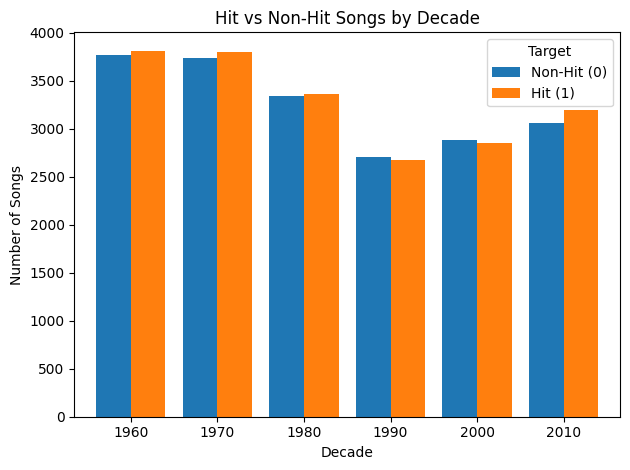

In [ ]:
count_df.plot(kind='bar', width=0.8)
plt.title('Hit vs Non-Hit Songs by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.xticks(rotation=0)
plt.legend(title='Target', labels=['Non-Hit (0)', 'Hit (1)'])
plt.tight_layout()
plt.show()

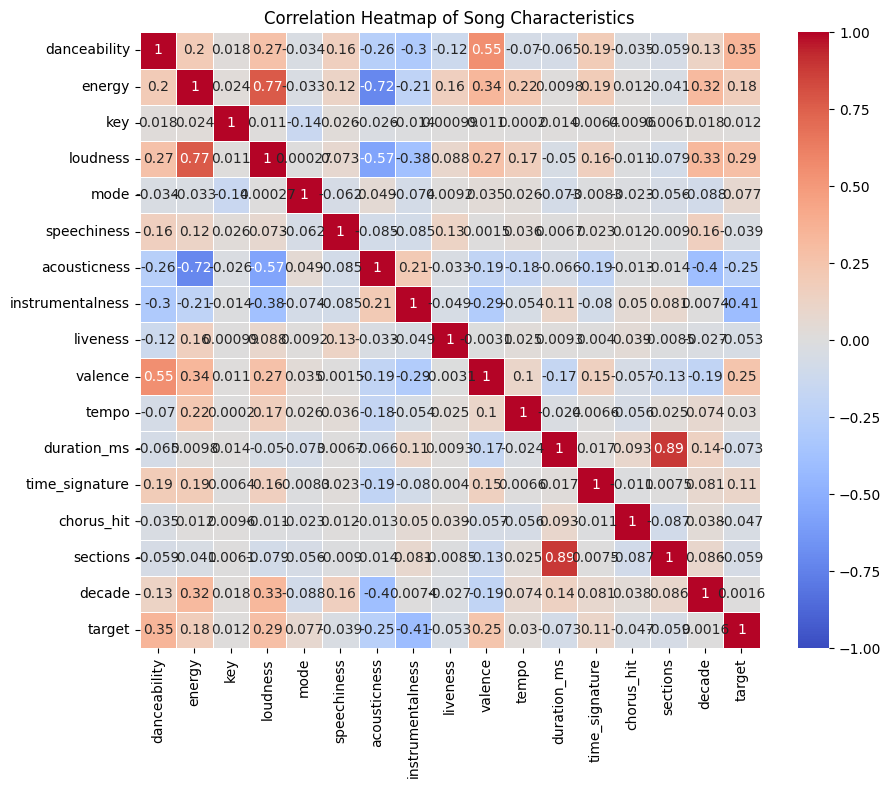

In [ ]:
# create a heatmap
features = df[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'decade', 'target']].dropna().apply(pd.to_numeric, errors='coerce')

correlation_matrix = features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, vmin = -1, vmax =1)
plt.title('Correlation Heatmap of Song Characteristics')
plt.show()

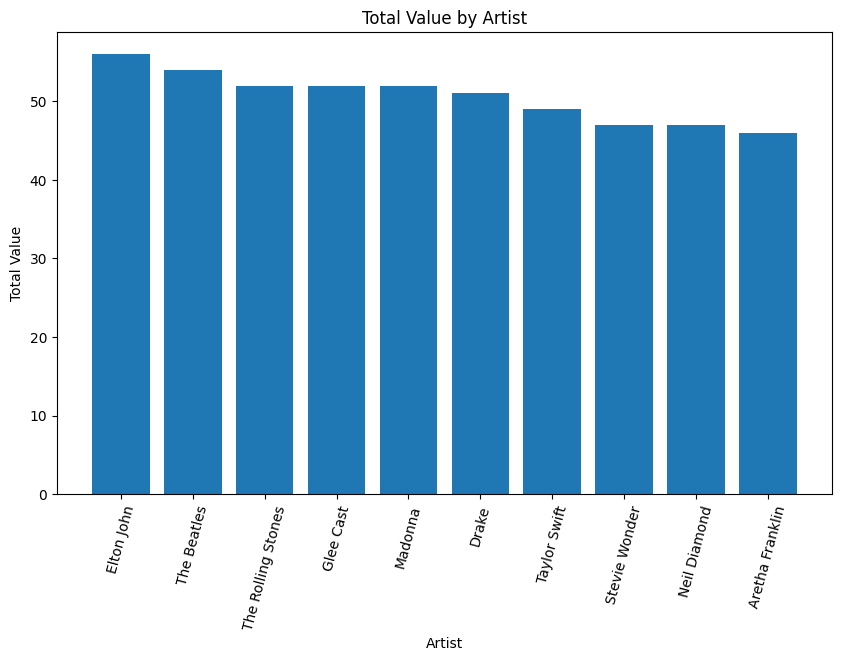

In [ ]:
# Top 10 artists by the number of hits
grouped = df.groupby('artist')['target'].sum().reset_index().sort_values(by="target", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(grouped['artist'], grouped['target'])
plt.xlabel('Artist')
plt.ylabel('Total Value')
plt.title('Total Value by Artist')
plt.xticks(rotation=75)
plt.show()

**We divide the data by hit & non-hit and compare the features**

In [ ]:
non_hit_df = df[df['target'] == 0]
hit_df = df[df['target'] == 1]

print("Non hit songs: ", len(non_hit_df))
print("Hit songs:", len(hit_df))
print("Ratio of Hit songs", len(hit_df) / len(df))

Non hit songs:  19483
Hit songs: 19695
Ratio of Hit songs 0.5027056000816785


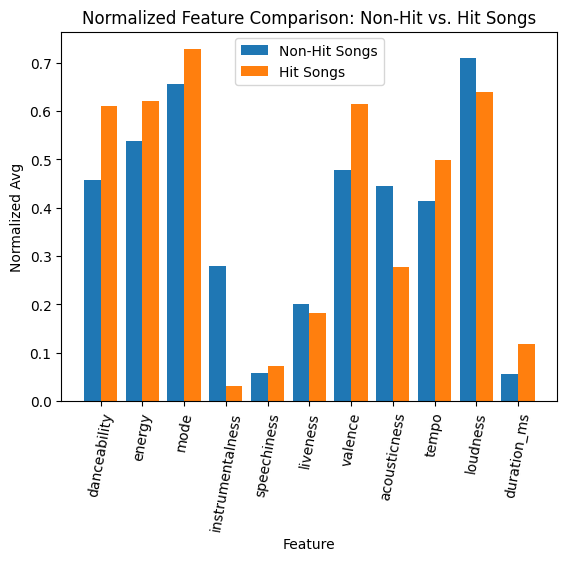

In [ ]:
parameters_to_normalize = ['danceability','energy','mode','instrumentalness','speechiness','liveness', 'valence','acousticness', 'tempo', 'loudness', 'duration_ms']

scaler = MinMaxScaler()

non_hit_df_normalized = pd.DataFrame(scaler.fit_transform(non_hit_df[parameters_to_normalize]), columns=parameters_to_normalize)
hit_df_normalized = pd.DataFrame(scaler.fit_transform(hit_df[parameters_to_normalize]), columns=parameters_to_normalize)

non_hit_df_avg = non_hit_df_normalized.mean()
hit_df_avg = hit_df_normalized.mean()

non_hit_values = list(non_hit_df_avg.values)
hit_values = list(hit_df_avg.values)

fig, ax = plt.subplots()

bar_width = 0.4

x = np.arange(len(parameters_to_normalize))
ax.bar(x - bar_width/2, non_hit_values, width=bar_width, label='Non-Hit Songs')
ax.bar(x + bar_width/2, hit_values, width=bar_width, label='Hit Songs')

ax.set_xticks(x)
ax.set_xticklabels(parameters_to_normalize)

ax.set_title('Normalized Feature Comparison: Non-Hit vs. Hit Songs')
ax.set_xlabel('Feature')
ax.set_ylabel('Normalized Avg')

ax.legend()

plt.xticks(rotation=80)
plt.show()


# Feature Engineering

**Add number of colloborations column**

Extract the colloborators from the artist column by the following delimiters:
*   Featuring
*   feat.
*   X or x
*   Symbols like +, -, ,, &, and /

In [ ]:
pattern = r"\b(?:Featuring|feat\.| X | x | \+ | - | , |, | & |/)\b"
df['Collabs'] = df['artist'].apply(lambda x: [artist.strip() for artist in re.split(pattern, x)])
df["Collaborators_#"] = df["Collabs"].apply(len)
df[["Collabs", "Collaborators_#"]].sort_values(by="Collaborators_#")

<ipython-input-22-176d0eea9c19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Collabs'] = df['artist'].apply(lambda x: [artist.strip() for artist in re.split(pattern, x)])
<ipython-input-22-176d0eea9c19>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Collaborators_#"] = df["Collabs"].apply(len)


,Collabs,Collaborators_#
0,[Alessia Cara],1
26502,[Mike Seeger],1
26503,[The Beatles],1
26504,[Al DeLory],1
26505,[Vicente Fernández],1
...,...,...
13514,"[Kirk Franklin, Mary J. Blige, Bono, R. Kelly,...",6
10213,"[B.G., Baby, Turk, Mannie Fresh, Juvenile, Lil...",6
3508,"[DJ Khaled, Nicki Minaj, Chris Brown, August A...",7
7239,"[DJ Khaled Feat. Akon, Plies, Young Jeezy, Ric...",7


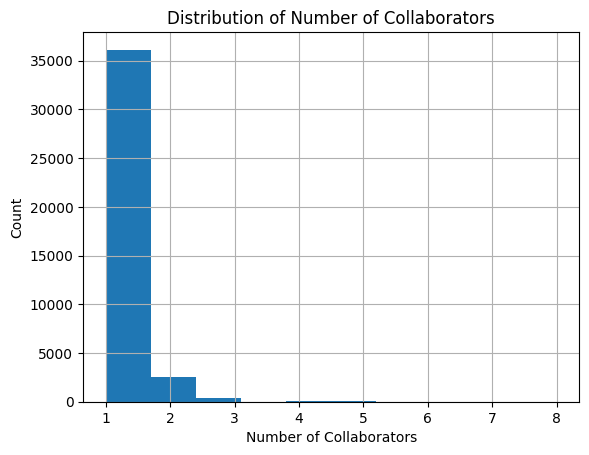

In [ ]:
# Plotting the histogram
df['Collaborators_#'].hist()
plt.title('Distribution of Number of Collaborators')
plt.xlabel('Number of Collaborators')
plt.ylabel('Count')
plt.show()

In [ ]:
# df = df.explode('artist').reset_index(drop=True)

Transform "decades" column

In [ ]:
df_decade = pd.get_dummies(df['decade'])
df_decade.columns

Index([1960, 1970, 1980, 1990, 2000, 2010], dtype='int64')

In [ ]:
df = pd.concat([df, df_decade], axis=1)

In [ ]:
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,Collabs,Collaborators_#
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,...,0.706,108.029,188493,4,41.18681,10,1,2010,[Alessia Cara],1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,...,0.250,155.489,176880,3,33.18083,9,0,2010,[Esquivel!],1
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,...,0.274,172.065,205463,4,44.89147,9,1,2010,[Lukas Graham],1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,...,0.291,91.837,193043,4,29.52521,7,0,2010,[Keys N Krates],1
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,...,0.780,160.517,144244,4,24.99199,8,1,2010,"[Zay Hilfigerrr, Zayion McCall]",2


**We transform the title into a numeric value (length of the title)**

Our assumption: shorter title might be more catchy and easier to remember

In [ ]:
# Count the number of words in the "track" column and assign to a new column "title_word_count"
df['title_word_count'] = df['track'].apply(lambda x: len(x.split()))

In [ ]:
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,decade,Collabs,Collaborators_#,1960,1970,1980,1990,2000,2010,title_word_count
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,...,2010,[Alessia Cara],1,False,False,False,False,False,True,2
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,...,2010,[Esquivel!],1,False,False,False,False,False,True,1
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,...,2010,[Lukas Graham],1,False,False,False,False,False,True,2
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,...,2010,[Keys N Krates],1,False,False,False,False,False,True,7
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,...,2010,"[Zay Hilfigerrr, Zayion McCall]",2,False,False,False,False,False,True,6


# Logistic Regression

<ipython-input-5-0b307564021f>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_data[variables] = (churn_data[variables] - churn_data[variables].min()) / (churn_data[variables].max() - churn_data[variables].min())
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC:  0.7875759682977473


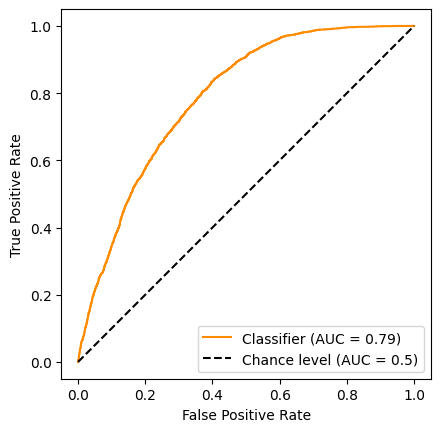

In [ ]:
base_features = ["artist"]
aggregate_functions = {
    "danceability": "mean",
    # "energy": "mean",0
    # "key": "count",0
    "loudness": "mean",
    # "mode": "count",0
    "speechiness": "mean",
    # "acousticness": "mean", X
    "instrumentalness": "mean",
    # "liveness": "mean",0
    # "valence": "mean",0
    # "tempo": "mean",0
    "duration_ms": "mean",
    # "time_signature": "count",
    # "chorus_hit": "mean",
    # "sections": "count",
    # "Collaborators_#": "count", -
}
col_names = [
    "avg_danceability",
    # "avg_energy",0
    # "count_key",0
    "avg_loudness",
    # "count_mode",0
    "avg_speechiness",
    # "avg_acousticness",X
    "avg_instrumentalness",
    # "avg_liveness",0
    # "avg_valence",0
    # "avg_tempo",0
    "avg_duration_ms",
    # "count_time_signature",
    # "avg_chorus_hit",
    # "count_sections",
    # "count_Collaborators_#" -
]
df_features = create_features(df, base_features, aggregate_functions, col_names)
dependent_variable = ['target']
independent_variables = [
    'danceability',
    # 'energy',0
    # 'key',0
    'loudness',
    # 'mode',0
    'speechiness',
    # 'acousticness', X
    'instrumentalness',
    # 'liveness',0
    # 'valence',0
    # 'tempo',0
    'duration_ms',
    # 'time_signature',
    # 'chorus_hit',
    # 'sections',
    # 'Collaborators_#' -
]
X = df[independent_variables]
y = df[dependent_variable]

df_norm = normalize_columns(df, independent_variables[:])
X = df_norm[independent_variables]
X = sm.add_constant(X)
y = df_norm[dependent_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LogisticRegression(solver = "liblinear").fit(X_train, y_train)

plot_result(X_test, y_test, clf)

# Decision Tree

In [ ]:
cont_cols = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'chorus_hit',
    'Collaborators_#'
]
cat_cols = [
    'key',
    'mode',
    'time_signature',
    'sections',
    'decade',
    'title_word_count'
]

In [ ]:
x, x_norm, y = format_dataset(df.copy(), cat_cols, cont_cols)
x_trn, x_val, y_trn, y_val = train_test_split(x_norm, y, test_size=0.15, stratify=y)

In [ ]:
best_params =  {'ccp_alpha': 0.0, 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 20}


# D4 - your code here
x_trn, x_val, y_trn, y_val = train_test_split(x_norm, y, test_size=0.15, stratify=y)
model = DecisionTreeClassifier(**best_params)
model.fit(x_trn, y_trn)

y_trn_pred = model.predict(x_trn)
y_val_pred = model.predict(x_val)

auc_train_score = roc_auc_score(y_trn, y_trn_pred)
auc_valid_score = roc_auc_score(y_val, y_val_pred)

print("AUC train: {:.03f}".format(auc_train_score))
print("AUC valid: {:.03f}".format(auc_valid_score))

print("\n")

print(f"Tree depth: {model.tree_.max_depth}")
print(f"Tree node count: {model.tree_.node_count}")
print(f"Tree leaf node count: {model.tree_.n_leaves}")

print(f"Data row count {x_norm.shape[0]}")
print(f"Data per leaf node (avg): {x_norm.shape[0] / model.tree_.n_leaves}")

AUC train: 0.802
AUC valid: 0.775


Tree depth: 10
Tree node count: 807
Tree leaf node count: 404
Data row count 39178
Data per leaf node (avg): 96.97524752475248


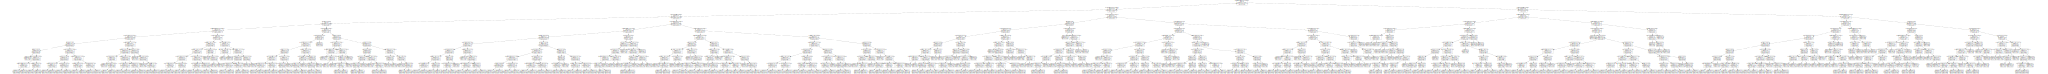

In [ ]:
g = export_graphviz(
    model,
    feature_names=x.columns,
    class_names=["Hit", "Flop"],
)

graphviz.Source(g)

In [ ]:
imp_scores = model.feature_importances_
imp_df = pd.DataFrame({
    "feat_imp_scores": imp_scores,
    "feat": x.columns
})

imp_df = imp_df[imp_df["feat_imp_scores"] > 0].sort_values("feat_imp_scores", ascending=False)
imp_df.head(10)

NameError: name 'model' is not defined

In [ ]:
x_trn, x_val, y_trn, y_val = train_test_split(x_norm, y, test_size=0.15, stratify=y)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, bootstrap=False, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)
rf_model.fit(x_trn, y_trn)

y_trn_pred = rf_model.predict(x_trn)
y_val_pred = rf_model.predict(x_val)

auc_train_score = roc_auc_score(y_trn, y_trn_pred)
auc_valid_score = roc_auc_score(y_val, y_val_pred)

print("AUC train: {:.03f}".format(auc_train_score))
print("AUC valid: {:.03f}".format(auc_valid_score))

AUC train: 0.940
AUC valid: 0.802


In [ ]:
x_trn, x_val, y_trn, y_val = train_test_split(x_norm, y, test_size=0.15, stratify=y)
best_params = {
    'colsample_bytree': 0.6,
    'gamma': 0.3,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 300,
    'subsample': 0.8
  }
# AUC train: 0.950
# AUC valid: 0.806
# Execution Time: 2520.367180585861 seconds
gb_model = XGBClassifier(**best_params)
gb_model.fit(x_trn, y_trn)

y_trn_pred = gb_model.predict(x_trn)
y_val_pred = gb_model.predict(x_val)

auc_train_score = roc_auc_score(y_trn, y_trn_pred)
auc_valid_score = roc_auc_score(y_val, y_val_pred)

print("AUC train: {:.03f}".format(auc_train_score))
print("AUC valid: {:.03f}".format(auc_valid_score))

AUC train: 0.960
AUC valid: 0.828


# Scraping data with GenAI
It will work but we didn't have time to run it and then combine with our dataset(

In [ ]:
# !wget -O spotify_missing_columns.csv https://drive.google.com/uc?id=1MxY1uIWpvFxGMbHgXYB5sEENc3fpw5u_
# !pip install openai --quiet

# from openai import OpenAI
# import pandas as pd
# import matplotlib.pyplot as plt

# from google.colab import userdata
# import os
# os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# client = OpenAI(
#     api_key= os.environ['OPENAI_API_KEY']
# )
# df_ms = pd.read_csv("spotify_missing_columns.csv")
# temperature = 0
# max_tokens = 400

# def promptTest(system_message: str,prompt: str,n: int, model = "gpt-4o-mini"):

#   output_dict = {}

#   temperature = 1
#   max_tokens = 500

#   i=0

#   while i<n:

#     completion = client.chat.completions.create(
#       model=model,
#       messages=[
#         {"role": "system", "content": system_message},
#         {"role": "user", "content": prompt}
#       ],
#       temperature=temperature,
#       max_tokens=max_tokens
#     )

#     output_dict[i] = completion.choices[0].message.content

#     i+=1

#   return output_dict


# def selfConsistencyTest(input_dict, model = "gpt-4o-mini"):

#   prompt = f"""What is the majority answer across the answers in the following dictionary?: '{input_dict}'
#              '
#              """

#   completion = client.chat.completions.create(
#     model=model,
#     messages=[
#       {"role": "system", "content": system_message},
#       {"role": "user", "content": prompt}
#     ],
#     temperature=temperature,
#     max_tokens=max_tokens
#   )

#   output = completion.choices[0].message.content

#   return output


# df_ms['danceability'] = None
# df_ms['speechiness'] = None
# df_ms['acousticness'] = None
# df_ms['instrumentalness'] = None
# df_ms['liveness'] = None

--2024-08-29 13:26:33--  https://drive.google.com/uc?id=1MxY1uIWpvFxGMbHgXYB5sEENc3fpw5u_
Resolving drive.google.com (drive.google.com)... 64.233.188.100, 64.233.188.113, 64.233.188.138, ...
Connecting to drive.google.com (drive.google.com)|64.233.188.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1MxY1uIWpvFxGMbHgXYB5sEENc3fpw5u_ [following]
--2024-08-29 13:26:33--  https://drive.usercontent.google.com/download?id=1MxY1uIWpvFxGMbHgXYB5sEENc3fpw5u_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384331 (375K) [application/octet-stream]
Saving to: ‘spotify_missing_columns.csv’

spotify_missing_col 100%[===================>] 375.32K  --.-KB/s    in 0.003s  

2024-08-29 13:26:36

In [ ]:
# for i in range(len(df_ms)):
#   system_message = "You are a very idealistic person."
#   chain_of_thought_prompt = f"""
#                             Answer the question: {df_ms.at[i, 'description']}
#                             Respond in the following format: 'danceability: X, speechiness: Y, acousticness: Z, instrumentalness: A, liveness: B"""
#   response = promptTest(system_message, chain_of_thought_prompt, 1)[0]
#   response = list(map(lambda x: [x[0], float(x[1])], map(lambda x: list(map(lambda y: y.strip(), x.strip().split(":"))), response.split(','))))
#   for j in response:
#     df_ms.at[i, j[0]] = j[1]